# Mining repos from GitHub

In [ ]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

os.chdir('D:\github_data')

Выставляем на [GitHub Search](https://seart-ghs.si.usi.ch/) следующие фильтры:

* язык Java
* 50+ звезд
* 1000+ коммитов
* 10+ контрибьюторов
* репозитории созданы не позднее 16 марта 2019 года (чтобы им было 2+ года)
* не берем форки
* не берем репозитории без лицензии

И скриншот, скорее чтобы удостовериться, что я все поставила правильно:

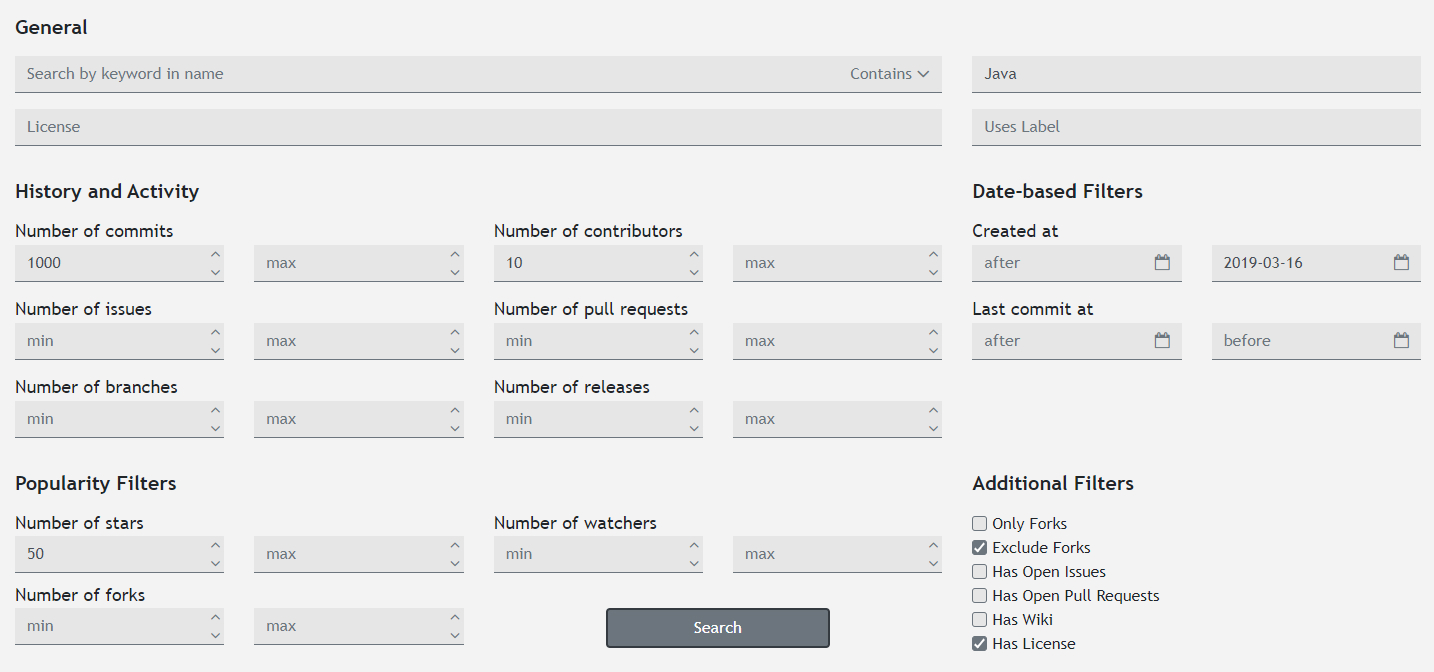

In [1]:
from IPython.display import Image
Image(filename='filters.jpg')

In [ ]:
filter_df = pd.read_csv('filter_results.csv')

Соберем через GitHub API дополнительную информацию о репозиториях, оставшихся после применения фильтров в GitHub Search.

In [ ]:
from github import Github

# using an access token
with open('access_token.txt') as file:
    access_token = file.readline().strip()
    
g = Github(access_token)

In [ ]:
repos = []
for name in filter_df['name']:
    try:
        repos.append(g.get_repo(name))
    except:
        print(name)
        repos.append(-1)

apache/axis2-java
boy0001/fastasyncworldedit


In [ ]:
full_names = []
git_urls = []
languages = []
is_ascii_description = []

for repo in repos:
    try:
        full_names.append(repo.full_name)
        git_urls.append(repo.git_url)
        languages.append(repo.language)
    except:
        full_names.append('')
        git_urls.append('')
        languages.append('null')
        
    try:
        is_ascii_description.append(repo.description.isascii())
    except:
        is_ascii_description.append(False)

In [ ]:
filter_df['full_name'] = full_names
filter_df['git_url'] = git_urls
filter_df['language'] = languages
filter_df['is_ascii_description'] = is_ascii_description

In [ ]:
filter_df['license'].unique()

array(['Other', 'GNU General Public License v2.0',
       'GNU General Public License v3.0', 'Apache License 2.0',
       'GNU Affero General Public License v3.0', 'MIT License',
       'GNU Lesser General Public License v3.0',
       'GNU Lesser General Public License v2.1',
       'BSD 2-Clause Simplified License', 'ISC License',
       'BSD 3-Clause New or Revised License',
       'Eclipse Public License 1.0', 'Eclipse Public License 2.0',
       'Mozilla Public License 2.0',
       'BSD 4-Clause Original or Old License',
       'Creative Commons Attribution Share Alike 4.0 International',
       'Creative Commons Zero v1.0 Universal',
       'European Union Public License 1.1',
       'Educational Community License v2.0', 'The Unlicense',
       'European Union Public License 1.2'], dtype=object)

Теперь еще больше пофильтруем репозитории:

1. Отбросим репозитории, где как основной язык указан не Java
2. Отбросим репозитории, где в описании присутствуют символы не из ASCII
3. Отбросим репозитории с лицензиями, отличными от Apache, MIT или BSD 3-Clause
4. Отбросим совпадения по `full_name` (которые могли появиться из-за переименования/переноса репозиториев)

In [ ]:
# leave repos only:
# 1. with Java as a main language
prev_len = len(filter_df)
print(f"Before additional filtering: {prev_len}")
res_df = filter_df.loc[filter_df['language'] == 'Java']
print(f"After dropping repos without language=Java: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")
prev_len = len(res_df)

# 2. with description without non-ascii symbols
res_df = res_df.loc[res_df['is_ascii_description']]
print(f"After dropping repos without ASCII-description: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")
prev_len = len(res_df)

# 3. with Apache / MIT / BSD license
res_df = res_df.loc[res_df['license'].isin(['Apache License 2.0', 'MIT License',
                                            'BSD 3-Clause New or Revised License'])]
print(f"After dropping repos without Apache/MIT/BSD licences: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")
prev_len = len(res_df)

# 4. drop duplicate repos
res_df = res_df.drop_duplicates(subset=['full_name'])
print(f"After dropping full_name duplicates: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")

res_df = res_df.sort_values(by='stargazers', ascending=False)

Before additional filtering: 2144
After dropping repos without language=Java: 2131, diff with previous step: 13
After dropping repos without ASCII-description: 1930, diff with previous step: 201
After dropping repos without Apache/MIT/BSD licences: 1008, diff with previous step: 922
After dropping full_name duplicates: 997, diff with previous step: 11


In [ ]:
res_df.head()

,name,fork project,commits,branches,default branch,releases,contributors,license,watchers,stargazers,...,last commit,last commit SHA,has wiki,is archived,languages,labels,full_name,git_url,language,is_ascii_description
1819,spring-projects/spring-boot,False,31276,13,master,87,382,Apache License 2.0,3450,53976,...,2021-03-15 15:25:53.0,b860d3892d0769219c7918279b50319c029fbdf5,True,False,"Java,HTML,Kotlin,Shell,JavaScript,Groovy,Ruby,...","for: external-project,for: merge-with-amendmen...",spring-projects/spring-boot,git://github.com/spring-projects/spring-boot.git,Java,True
1821,spring-projects/spring-framework,False,22321,15,master,202,390,Apache License 2.0,3484,41837,...,2021-03-13 17:03:34.0,9c030bacb83e833e64ef76599dfe6283b7c514cc,True,False,"Java,Kotlin,Groovy,AspectJ,FreeMarker,CSS,GAP,...","for: backport-to-4.3.x,for: backport-to-5.0.x,...",spring-projects/spring-framework,git://github.com/spring-projects/spring-framew...,Java,True
822,google/guava,False,5444,11,master,31,256,Apache License 2.0,2483,40563,...,2021-03-12 00:50:33.0,fe3fda0ca54076a2268d060725e9a6e26f867a5e,True,False,"Java,CSS,Shell,JavaScript","P0,P1,P2,P3,P4,cla: no,cla: yes,dependencies,f...",google/guava,git://github.com/google/guava.git,Java,True
1837,square/retrofit,False,1865,13,master,54,152,Apache License 2.0,1619,37601,...,2021-02-24 13:08:49.0,fbf1225e28e2094bec35f587b8933748b705d167,True,False,"Java,Kotlin,HTML,CSS,Shell","Blocked,Bug,Documentation,Enhancement,Feature,...",square/retrofit,git://github.com/square/retrofit.git,Java,True
1913,thealgorithms/java,False,1323,3,master,0,216,MIT License,2271,35997,...,2021-03-14 01:41:31.0,34c5edd11e468acb04d0da67834732a97ad36865,True,False,"Java,Dockerfile","Good First Issue,Status: Approved,Status: Docs...",TheAlgorithms/Java,git://github.com/TheAlgorithms/Java.git,Java,True


In [ ]:
print(f"{len(res_df)} repos and {res_df['commits'].sum()} commits")

997 repos and 4616411 commits


In [ ]:
res_df.to_csv('result.csv', index=None)
res_df['name'].to_csv('repos_names.txt', index=None, header=None)
res_df['git_url'].to_csv('repos_urls.txt', index=None, header=None)